<a href="https://www.kaggle.com/code/vamshiedward/tmdb-5000-movie-dataset?scriptVersionId=91279546" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv


In [2]:
import matplotlib.pyplot as plt # for platting graph
%matplotlib inline
import seaborn as sns # for data visulization
import warnings # to ignore any warnings
warnings.filterwarnings("ignore")
import json
import datetime
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

Expectation from the Notebook

This notebook is divided into the following sections:

1).Introduction to the problem

2).Exploratory Data Analysis (EDA) and PreProcessing

3).Model building and Feature engineering
Let’s look at the steps that we will follow in this notebook.

1).Problem Statement

2).Hypothesis Generation

3). Getting the system ready and loading the data

4).Understanding the data

5).Exploratory Data Analysis (EDA)
    i).Univariate Analysis
    ii).Bivariate Analysis

6).Missing value and outlier treatment

7).Evaluation Metrics for classification problems

8).Model Building : Part I

9).Logistic Regression using stratified k-folds cross validation

10).Feature Engineering

11).Model Building : Part II

    1).Logistic Regression
    2).Decision tree
    3).Random Forest
Lets look at each section in detail.

## Data Wrangling
## General Dataset Properties

In [3]:
movies = pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv")
credits = pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv")

In [4]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
credits.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
movies.shape, credits.shape

((4803, 20), (4803, 4))

In [7]:
movies.info(), credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

(None, None)

In [8]:
movies.columns, credits.columns

(Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
        'original_title', 'overview', 'popularity', 'production_companies',
        'production_countries', 'release_date', 'revenue', 'runtime',
        'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
        'vote_count'],
       dtype='object'),
 Index(['movie_id', 'title', 'cast', 'crew'], dtype='object'))

Features

•     budget: The budget of the movie in dollars.

•     genres: A stringified list of dictionaries that list out all the genres associated with the movie.

•     homepage: The Official Homepage of the move.

•     id: The ID of the movie.

•     original_language: The language in which the movie was originally shot in.

•     original_title: The original title of the movie.

•     overview: A brief blurb of the movie.

•     popularity: The Popularity Score assigned by TMDB.

•     production_companies: A stringified list of production companies involved with the making of the movie.

•     production_countries: A stringified list of countries where the movie was shot/produced in.

•     release_date: Theatrical Release Date of the movie.

•     revenue: The total revenue of the movie in dollars.

•     runtime: The runtime of the movie in minutes.

•     spoken_languages: A stringified list of spoken languages in the film.

•     status: The status of the movie (Released, To Be Released, Announced, etc.)

•     tagline: The tagline of the movie.

•     title: The Official Title of the movie.

•     vote_average: The average rating of the movie.

• vote_count: The number of votes by users, as counted by TMDB.

In [9]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Now lets look at the correlation between all the numerical variables. We will use the heat map to visualize the correlation. Heatmaps visualize data through variations in coloring. The variables with darker color means their correlation is more.

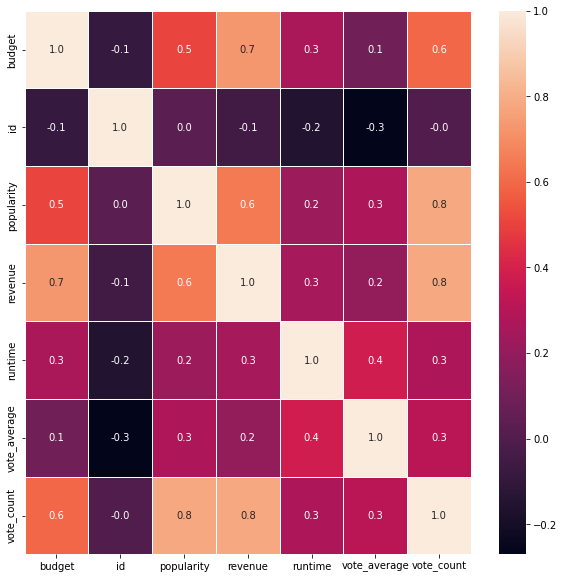

In [10]:
# correlation map
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(movies.corr(), annot = True, linewidths=.5, fmt = '.1f', ax = ax)
plt.show()

We see that the most correlated variables are (budget - popularity, revenue, vote_count) runtime is also correlated with vote_average.

## Null values

In [11]:
#null values
movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

we are not intersted in the feature "homepage","tagline" so we will drop them later.

In [12]:
credits.isnull().sum()

movie_id    0
title       0
cast        0
crew        0
dtype: int64

# Runtime null values

In [13]:
movies.loc[movies.runtime.isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0



we set them to the mean runtime

Release date null value

In [14]:
movies.loc[movies.release_date.isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaN,0,0.0,[],Released,NaN,America Is Still the Place,0.0,0


Data is useless so we drop it

In [15]:
movies = movies.loc[movies.release_date.notnull()]

Overview null values

We don't really use the overview feature, but we can easily fix the null values

In [16]:
movies.overview.fillna("Unsepecified",inplace=True)

# Zero values

In [17]:
movies.apply(lambda x: sum(x==0),axis=0)

budget                  1036
genres                     0
homepage                   0
id                         0
keywords                   0
original_language          0
original_title             0
overview                   0
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                 1426
runtime                   34
spoken_languages           0
status                     0
tagline                    0
title                      0
vote_average              62
vote_count                61
dtype: int64

Revenue and budget

Since our primary objective is predicting revenue, we will drop the zero valued revenues and budgets

In [18]:
outerlier_thresh = 1000
movies = movies[movies.budget>outerlier_thresh]
movies = movies[movies.revenue>outerlier_thresh]
len(movies)

3211

In [19]:
zero_values = movies.apply(lambda x: sum(x==0), axis = 0)
zero_values[zero_values>0]

vote_average    2
vote_count      2
dtype: int64

Vote count and average

In [20]:
movies = movies[movies.vote_count>0]

In [21]:
zero_values = movies.apply(lambda x: sum(x==0), axis = 0)
zero_values[zero_values>0]

Series([], dtype: int64)



No more zero values

## JSON Handling

We still have some columns in json format


In [22]:
columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
for col in columns:
    movies[col] = movies[col].apply(json.loads)
movies['release_date'] =  pd.to_datetime(movies['release_date'], format ='%Y-%m-%d')

In [23]:
movies["genres"][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

A movie can have several genres.

In [24]:
movies["keywords"][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [25]:
# We extract the names from the json data
for col in columns: 
    movies[col] = movies[col].map(lambda x:[i['name'] for i in x])

movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [26]:
movies['year'] = movies['release_date'].map(lambda dates: dates.year)

movies['release_date'] = movies['release_date'].map(lambda dates: datetime.datetime.strptime(str(dates), '%Y-%m-%d %H:%M:%S'))
movies['day_of_year'] = movies['release_date'].map(lambda dates: dates.timetuple().tm_yday)

movies['year'] = movies['release_date'].map(lambda dates: dates.year)

movies['month'] = movies['release_date'].map(lambda dates: dates.month)

In [27]:
columns = ['cast', 'crew']

for col in columns: 
    credits[col] = credits[col].apply(json.loads)
    
credits['cast'] = credits['cast'].map(lambda x:[ [i['name'],i['gender']] for i in x])
credits['crew'] = credits['crew'].map(lambda x:[ [i['name'],i['job'],i['department'],i['gender']] for i in x])

In [28]:
credits.cast[0][:8]

[['Sam Worthington', 2],
 ['Zoe Saldana', 1],
 ['Sigourney Weaver', 1],
 ['Stephen Lang', 2],
 ['Michelle Rodriguez', 1],
 ['Giovanni Ribisi', 2],
 ['Joel David Moore', 2],
 ['CCH Pounder', 1]]

In [29]:
credits.crew[0][:8]

[['Stephen E. Rivkin', 'Editor', 'Editing', 0],
 ['Rick Carter', 'Production Design', 'Art', 2],
 ['Christopher Boyes', 'Sound Designer', 'Sound', 0],
 ['Christopher Boyes', 'Supervising Sound Editor', 'Sound', 0],
 ['Mali Finn', 'Casting', 'Production', 1],
 ['James Horner', 'Original Music Composer', 'Sound', 2],
 ['James Cameron', 'Director', 'Directing', 2],
 ['James Cameron', 'Writer', 'Writing', 2]]

According to TMDB, 0 corresponds to 'not set', 1 to 'Female' and 2 to 'Male'.

## Exploratory Data Analysis¶

## Research Part 1: General Explore

Question 1: Movie title

In [30]:
count_title = movies.groupby('title').title.count()
count_title[count_title != 1]

title
The Host    2
Name: title, dtype: int64

In [31]:
double_title = count_title[count_title != 1].index.values

movies.title = movies.apply(lambda row: row.title+'_'+str(row.release_date) if (row.title in double_title) else row.title,axis = 1)

count_title = movies.groupby('title').title.count()
count_title[count_title != 1]

Series([], Name: title, dtype: int64)

## Movies budget

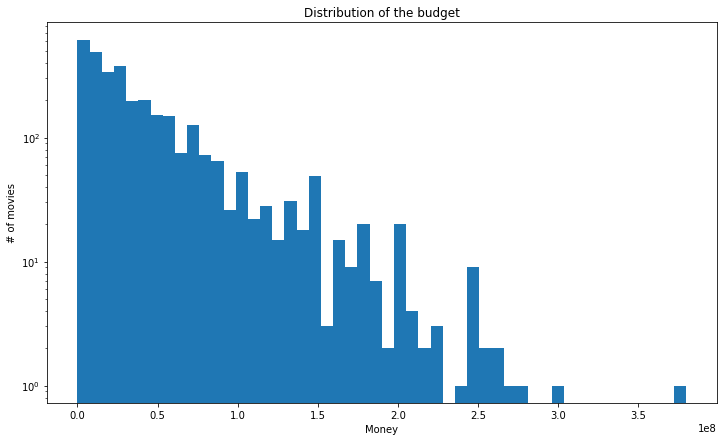

In [32]:
plt.figure(figsize=(12,7))
plt.hist(movies['budget'],bins= 50)
plt.title("Distribution of the budget")
plt.xlabel('Money')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

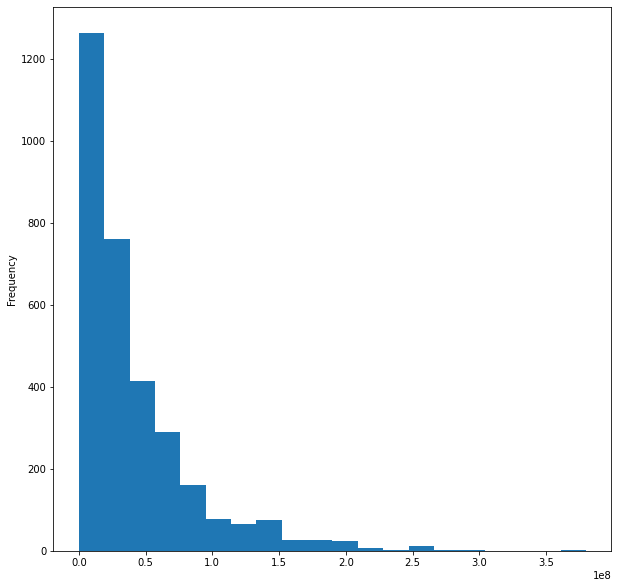

In [33]:
# Histogram
movies.budget.plot(kind='hist', bins = 20, figsize = (10,10))
plt.show()

## Revenue

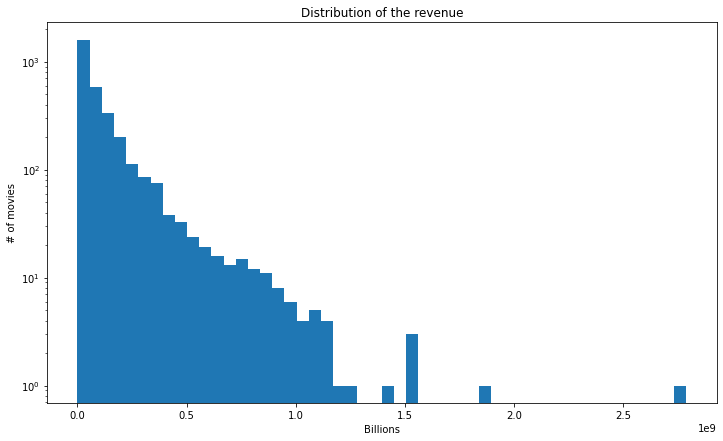

In [34]:
plt.figure(figsize=(12,7))
plt.hist(movies['revenue'],bins= 50)
plt.title("Distribution of the revenue")
plt.xlabel('Billions')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

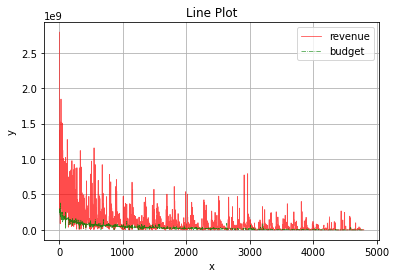

In [35]:
# Line plot
movies.revenue.plot(kind='line', color='r', label='revenue', linewidth=.8, alpha=.7, grid=True, linestyle='-' )
movies.budget.plot(color='g', label='budget', linewidth=.7, alpha=.8, grid=True, linestyle='-.')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Plot')
plt.show()

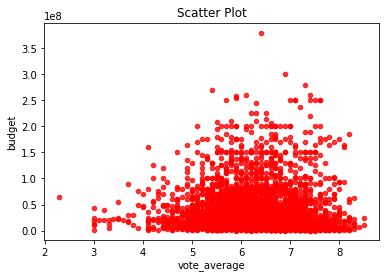

In [36]:
# Scatter Plot
movies.plot(kind='scatter', x='vote_average', y='budget', alpha=.8, color='r')
plt.xlabel('vote_average')
plt.ylabel('budget')
plt.title('Scatter Plot')
plt.show()

## Genres

In [37]:
movies_genres = movies.explode("genres")
movies_genres

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year,day_of_year,month
0,237000000,Action,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
0,237000000,Adventure,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
0,237000000,Fantasy,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
0,237000000,Science Fiction,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
1,300000000,Adventure,http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",...,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,139,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,7000,Drama,http://www.primermovie.com,14337,"[distrust, garage, identity crisis, time trave...",en,Primer,Friends/fledgling entrepreneurs invent a devic...,23.307949,[Thinkfilm],...,77.0,[English],Released,What happens if it actually works?,Primer,6.9,658,2004,282,10
4796,7000,Thriller,http://www.primermovie.com,14337,"[distrust, garage, identity crisis, time trave...",en,Primer,Friends/fledgling entrepreneurs invent a devic...,23.307949,[Thinkfilm],...,77.0,[English],Released,What happens if it actually works?,Primer,6.9,658,2004,282,10
4798,220000,Action,NaN,9367,"[united states–mexico barrier, legs, arms, pap...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,[Columbia Pictures],...,81.0,[Español],Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,1992,248,9
4798,220000,Crime,NaN,9367,"[united states–mexico barrier, legs, arms, pap...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,[Columbia Pictures],...,81.0,[Español],Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,1992,248,9


In [38]:
movies_genres.genres.unique()

array(['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime',
       'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy',
       'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music',
       'Documentary', 'Foreign', nan], dtype=object)

In [39]:
#genres total count
count_genres = movies_genres.groupby('genres').count()[['id']].sort_values(by='id', ascending=False)
count_genres.head()

,id
genres,
Drama,1428
Comedy,1101
Thriller,930
Action,915
Adventure,660


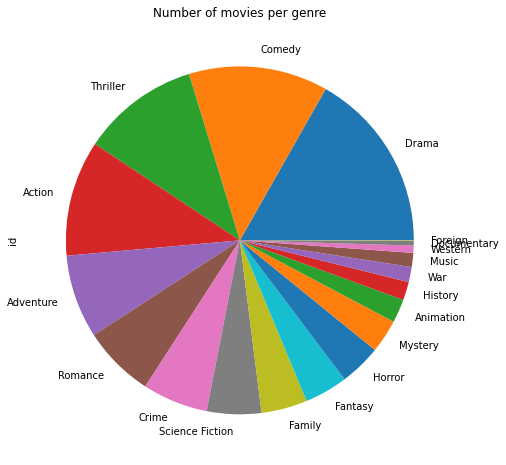

In [40]:
count_genres.plot(kind ='pie',figsize=(10,8),legend = False, subplots = True)
plt.title('Number of movies per genre')
plt.show()

What genre make the most money ?

In [41]:
genres_revenue = movies[['genres','revenue']].explode('genres')
genres_revenue.head()

,genres,revenue
0,Action,2787965087
0,Adventure,2787965087
0,Fantasy,2787965087
0,Science Fiction,2787965087
1,Adventure,961000000


In [42]:
genres_revenue = genres_revenue.groupby("genres")[["revenue"]].sum()
genres_revenue.head()

,revenue
genres,
Action,162316088206
Adventure,163667924225
Animation,52436463168
Comedy,120403594524
Crime,45797218000


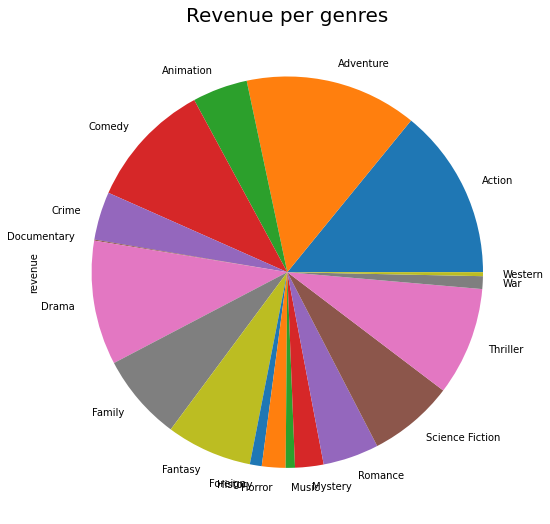

In [43]:
genres_revenue.plot(kind ='pie',figsize=(10,9),legend = False, subplots = True)
plt.title('Revenue per genres', fontsize=20)
plt.show()

Popularity Over Years

In [44]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year,day_of_year,month
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",...,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,139,5


In [45]:
movies['release_date']=pd.to_datetime(movies['release_date'], format='%Y-%m-%d')
release_year = pd.DatetimeIndex(movies['release_date']).year
release_year
movies['release_year'] = release_year

In [46]:
# compute the mean for popularity
p_mean = movies.groupby('release_year').mean()['popularity']
p_mean.tail()

release_year
2012    35.457552
2013    38.822408
2014    61.606583
2015    63.820730
2016    51.806021
Name: popularity, dtype: float64

In [47]:
# compute the median for popularity
p_median = movies.groupby('release_year').median()['popularity']
p_median.tail()

release_year
2012    27.908783
2013    34.858123
2014    42.472324
2015    40.814793
2016    42.519413
Name: popularity, dtype: float64

In [48]:
# build the index location for x-axis
index_mean = p_mean.index
index_median = p_median.index

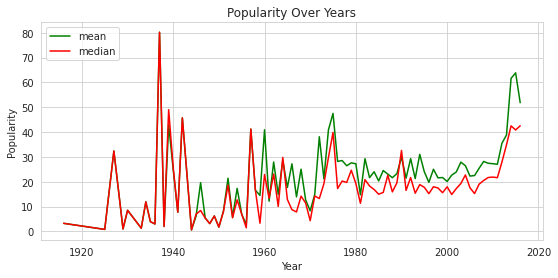

In [49]:
#set style
sns.set_style('whitegrid')
#set x, y axis data
#x1, y1 for mean data; x2, y2 for median data
x1, y1 = index_mean, p_mean
x2, y2 = index_median, p_median
#set size
plt.figure(figsize=(9, 4))
#plot line chart for mean and median
plt.plot(x1, y1, color = 'g', label = 'mean')
plt.plot(x2, y2, color = 'r', label = 'median')
#set title and labels
plt.title('Popularity Over Years')
plt.xlabel('Year')
plt.ylabel('Popularity');
#set legend
plt.legend(loc='upper left')


Popularity

Metric computed by TMDB and taking into account :

    Number of votes for the day
    Number of views for the day
    Number of users who marked it as a "favourite" for the day
    Number of users who added it to their "watchlist" for the day
    Release date
    Number of total votes
    Previous days score



In [50]:
df_movie_pop = movies[["title","popularity"]].sort_values(by="popularity", ascending=False)
df_movie_pop.head()

,title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564


## Research Part 2 : Find the Properties are Associated with Successful Movies
## Function Prepare-- Build a level-devide function and a split string function.

In [51]:
# quartile function
def cut_into_quantile(dfname ,column_name):
# find quartile, max and min values
    min_value = dfname[column_name].min()
    first_quantile = dfname[column_name].describe()[4]
    second_quantile = dfname[column_name].describe()[5]
    third_quantile = dfname[column_name].describe()[6]
    max_value = dfname[column_name].max()
# Bin edges that will be used to "cut" the data into groups
    bin_edges = [ min_value, first_quantile, second_quantile, third_quantile, max_value]
# Labels for the four budget level groups
    bin_names = [ 'Low', 'Medium', 'Moderately High', 'High'] 
# Creates budget_levels column
    name = '{}_levels'.format(column_name)
    dfname[name] = pd.cut(dfname[column_name], bin_edges, labels=bin_names, include_lowest = True)
    return dfname

## B. Sample prepare-- Filter Top 100 and Worst 100 movies in each year as the research sample.¶
## A) Select Top 100 popular movies in every year.

In [52]:
# split pipe characters and count their number of appeared times
#argument:dataframe_col is the target dataframe&column; num is the number of the top factor
def find_top(dataframe_col, num=3):
    # split the characters in the input column 
    #and make it to a list
    alist = dataframe_col.str.cat(sep='|').split('|')
    #transfer it to a dataframe
    new = pd.DataFrame({'top' :alist})
    #count their number of appeared times and
    #choose the top3
    top = new['top'].value_counts().head(num)
    return top

B) Select Top 100 high revenue movies in every year.

In [53]:
# Select Top 100 popular movies.
# fisrt sort it by release year ascending and popularity descending
df_top_p = movies.sort_values(['release_year','popularity'], ascending=[True, False])
#group by year and choose the top 100 high
df_top_p = df_top_p.groupby('release_year').head(100).reset_index(drop=True)
#check, it must start from 1960, and with high popularity to low
df_top_p.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,year,day_of_year,month,release_year
0,385907,[Drama],NaN,3059,"[usa, naivety, intolerance, mill, marriage, we...",en,Intolerance,"The story of a poor young woman, separated by ...",3.232447,"[Triangle Film Corporation, Wark Producing Corp.]",...,[English],Released,The Cruel Hand of Intolerance,Intolerance,7.4,60,1916,248,9,1916
1,245000,"[Drama, Romance, War]",NaN,3060,"[world war i, silent film]",en,The Big Parade,The story of an idle rich boy who joins the US...,0.785744,[Metro-Goldwyn-Mayer (MGM)],...,[],Released,NaN,The Big Parade,7.0,21,1925,309,11,1925


In [54]:
# Select Top 100 high revenue movies.
# fisrt sort it by release year ascending and revenue descending
df_top_r = movies.sort_values(['release_year','revenue'], ascending=[True, False])
#group by year and choose the top 100 high
df_top_r = df_top_r.groupby('release_year').head(100).reset_index(drop=True)
#check, it must start from 1960, and with high revenue to low
df_top_r.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,year,day_of_year,month,release_year
0,385907,[Drama],NaN,3059,"[usa, naivety, intolerance, mill, marriage, we...",en,Intolerance,"The story of a poor young woman, separated by ...",3.232447,"[Triangle Film Corporation, Wark Producing Corp.]",...,[English],Released,The Cruel Hand of Intolerance,Intolerance,7.4,60,1916,248,9,1916
1,245000,"[Drama, Romance, War]",NaN,3060,"[world war i, silent film]",en,The Big Parade,The story of an idle rich boy who joins the US...,0.785744,[Metro-Goldwyn-Mayer (MGM)],...,[],Released,NaN,The Big Parade,7.0,21,1925,309,11,1925


C) Select Top 100 high score rating movies in every year.

In [55]:
# Select Top 100 high scorer ating movies.
# fisrt sort it by release year ascending and high scorer ating descending
df_top_s = movies.sort_values(['release_year','vote_average'], ascending=[True, False])
#group by year and choose the top 100 high
df_top_s = df_top_s.groupby('release_year').head(100).reset_index(drop=True)
#check, it must start from 1960, and with high scorer ating to low
df_top_s.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,year,day_of_year,month,release_year
0,385907,[Drama],NaN,3059,"[usa, naivety, intolerance, mill, marriage, we...",en,Intolerance,"The story of a poor young woman, separated by ...",3.232447,"[Triangle Film Corporation, Wark Producing Corp.]",...,[English],Released,The Cruel Hand of Intolerance,Intolerance,7.4,60,1916,248,9,1916
1,245000,"[Drama, Romance, War]",NaN,3060,"[world war i, silent film]",en,The Big Parade,The story of an idle rich boy who joins the US...,0.785744,[Metro-Goldwyn-Mayer (MGM)],...,[],Released,NaN,The Big Parade,7.0,21,1925,309,11,1925


D) To compare to results, I also create three subdataset for the last 100 movies.

In [56]:
# the last 100 popular movies in every year
df_low_p = movies.sort_values(['release_year','popularity'], ascending=[True, True])
df_low_p = df_low_p.groupby('release_year').head(100).reset_index(drop=True)
print('\n{:s}'.format('\u0332'.join("THE LAST 100 POPULAR MOVIES IN EVERY YEAR:\n")))
print(df_low_p)
# the last 100 high revenue movies in every year
df_low_r = movies.sort_values(['release_year','revenue'], ascending=[True, True])
df_low_r = df_low_r.groupby('release_year').head(100).reset_index(drop=True)
print('\n{:s}'.format('\u0332'.join("THE LAST 100 HIGH REVENUE MOVIES IN EVERY YEAR:\n")))
print(df_low_r)
# the last 100 score rating movies in every year
df_low_s = movies.sort_values(['release_year','vote_average'], ascending=[True, True])
df_low_s = df_low_s.groupby('release_year').head(100).reset_index(drop=True)
print('\n{:s}'.format('\u0332'.join("THE LAST 100 SCORE RATING MOVIES IN EVERY YEAR:")))
print(df_low_s)


T̲H̲E̲ ̲L̲A̲S̲T̲ ̲1̲0̲0̲ ̲P̲O̲P̲U̲L̲A̲R̲ ̲M̲O̲V̲I̲E̲S̲ ̲I̲N̲ ̲E̲V̲E̲R̲Y̲ ̲Y̲E̲A̲R̲:̲

         budget                                genres  \
0        385907                               [Drama]   
1        245000                 [Drama, Romance, War]   
2      92620000              [Drama, Science Fiction]   
3        379000               [Drama, Music, Romance]   
4       3950000              [Action, Drama, History]   
...         ...                                   ...   
2602  175000000   [Family, Adventure, Drama, Fantasy]   
2603  178000000                     [Science Fiction]   
2604  250000000          [Action, Adventure, Fantasy]   
2605  250000000  [Adventure, Action, Science Fiction]   
2606   58000000           [Action, Adventure, Comedy]   

                                              homepage      id  \
0                                                  NaN    3059   
1                                                  NaN    3060   
2                             

What's the runtime level are associated with movies that have high popularity on average?

In [57]:
movies = cut_into_quantile(movies,'runtime')
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title,vote_average,vote_count,year,day_of_year,month,release_year,runtime_levels
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12,2009,High


In [58]:
# Find the mean popularity of each level with groupby
result_mean = movies.groupby('runtime_levels')['popularity'].mean()
result_mean

runtime_levels
Low                23.561147
Medium             24.104017
Moderately High    29.643336
High               40.046617
Name: popularity, dtype: float64

In [59]:
# Find the median popularity of each level with groupby
result_median = movies.groupby('runtime_levels')['popularity'].median()
result_median

runtime_levels
Low                17.537154
Medium             18.228538
Moderately High    21.246013
High               28.803729
Name: popularity, dtype: float64

In [60]:
ind = np.arange(len(result_median))  # the x locations for the groups
width = 0.5       # the width of the bars

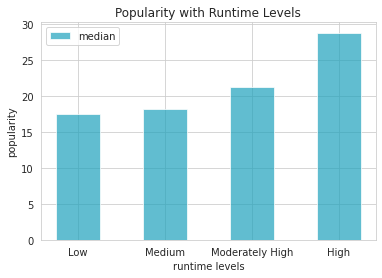

In [61]:
# plot bars
bars = plt.bar(ind, result_median, width, color='#1ea2bc', alpha=.7, label='median')

# title and labels
plt.ylabel('popularity')
plt.xlabel('runtime levels')
plt.title('Popularity with Runtime Levels')
locations = ind  # xtick locations，345...
labels = result_median.index  
plt.xticks(locations, labels)
# legend
plt.legend() 



We will not keep it as feature.
## ML model

We would like to develop a model to predict movie's revenue.


One hot encoding

In [62]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'year', 'day_of_year', 'month', 'release_year',
       'runtime_levels'],
      dtype='object')

In [63]:


features_kept = ['title','keywords','budget','genres','popularity', 'production_companies', 
                'production_countries', 'year' ,'day_of_year','month','revenue', 'runtime', 'spoken_languages',
                'vote_average', 'vote_count',]

data = movies[features_kept].set_index('title')
data=data[data["year"]>1960]
data.head()

,keywords,budget,genres,popularity,production_companies,production_countries,year,day_of_year,month,revenue,runtime,spoken_languages,vote_average,vote_count
title,,,,,,,,,,,,,,
Avatar,"[culture clash, future, space war, space colon...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009,344,12,2787965087,162.0,"[English, Español]",7.2,11800
Pirates of the Caribbean: At World's End,"[ocean, drug abuse, exotic island, east india ...",300000000,"[Adventure, Fantasy, Action]",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007,139,5,961000000,169.0,[English],6.9,4500
Spectre,"[spy, based on novel, secret agent, sequel, mi...",245000000,"[Action, Adventure, Crime]",107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015,299,10,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",6.3,4466
The Dark Knight Rises,"[dc comics, crime fighter, terrorist, secret i...",250000000,"[Action, Crime, Drama, Thriller]",112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012,198,7,1084939099,165.0,[English],7.6,9106
John Carter,"[based on novel, mars, medallion, space travel...",260000000,"[Action, Adventure, Science Fiction]",43.926995,[Walt Disney Pictures],[United States of America],2012,67,3,284139100,132.0,[English],6.1,2124


In [64]:
data.shape

(3145, 14)

We explode the lists that we have and transform them as dummy variable.